In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Node class
#Creats new nodes
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        ''' constructor ''' 
        
        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
        # for leaf node
        self.value = value

In [3]:
# Class for Tree

class DecisionTreeClassifier():
    #initialising function
    def __init__(self, min_samples_split=2, max_depth=2):
        ''' constructor '''
        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    #build tree if the classified class is impure   
    #useing Node class defined above
    def build_tree(self, dataset, curr_depth=0):
        ''' recursive function to build the tree ''' 
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["info_gain"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    #get best split using gini index
    def get_best_split(self, dataset, num_samples, num_features):
        ''' function to find the best split '''
        
        # dictionary to store the best split
        best_split = {}
        max_info_gain = -float("inf")
        
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y, "gini")
                    # update the best split if needed
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
                        
        # return best split
        return best_split
    
    #split the dataset 
    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    #calculate the gain, that is how much less loss occurs due to a split according to gini value
    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        ''' function to compute information gain '''
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode=="gini":
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain
    
    def entropy(self, y):
        ''' function to compute entropy '''
        
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy
    
    #calculate gini index value
    def gini_index(self, y):
        ''' function to compute gini index '''
        
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini
        
    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node '''
        
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y):
        ''' function to train the tree '''
        
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
    
    def predict(self, X):
        ''' function to predict new dataset '''
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def make_prediction(self, x, tree):
        ''' function to predict a single data point '''
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

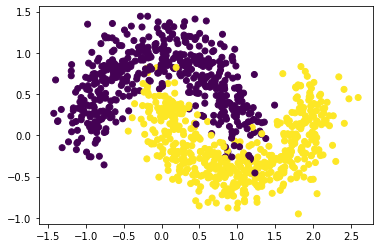

In [8]:
from sklearn.datasets import make_moons
N= 1000
X,Y = make_moons(N, noise=0.2)
plt.scatter(X[:,0], X[:,1], c=Y)
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
Y = Y..reshape(-1,1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=41)

In [10]:
classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=3)
classifier.fit(X_train,Y_train)
classifier.print_tree()

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)